# Aula 7

---

**Saulo Martiello Mastelini**<br>
Candidato a Ph.D. pelo ICMC-USP<br>
Online Machine Learning

Página pessoal: [smastelini](https://smastelini.github.io/)</br>
e-mail: saulomastelini@gmail.com

---

- Árvores: revisitadas
    - Quais são os parâmetros mais sensíveis
    - Função de split
    - Critérios de parada
    - Notas sobre minha experiência pessoal
- Ensembles
    - Bagging
- Viés e variância
     - Demonstrar quando o bagging funciona e falha, de acordo com a variância do preditor
- Random Patches
- Random Forest

---

# 1. Árvores de decisão

- Dividir para conquistar
- Estruturas hierárquicas
- Construção recursiva
- Seleção de features:
    - Quanto mais acima na árvore, mais importante
    - O caminho da raíz à folha também pode ser utilizado como indicativo de importância
- Interpretabilidade



In [1]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

## 1.1. Split na prática

Vamos relembrar como os splits em uma árvore de decisão ocorrem na prática.

Primeiro, vou escolher uma heurística de classificação para fazermos o teste.

Por simplicidade, utilizarei a entropia e o ganho de informação:

$E = -\sum_i^C p_i\log_2 p_i$

(caso com splits binários)

$IG = E(y) - \dfrac{|y_L|}{|y|}E(y_L) - \dfrac{|y_R|}{|y|}E(y_R)$

In [2]:
import numpy as np


def entropy(y):
    n = len(y)
    _, cnts = np.unique(y, return_counts=True)

    entropy = 0
    for c in cnts:
        p_i = c / n
        entropy += (p_i * np.log2(p_i))
    return -entropy

def info_gain(x, y, limiar):
    n = len(y)
    y_l = y[x <= limiar]
    y_r = y[x > limiar]

    return entropy(y) - (len(y_l) / n) * entropy(y_l) - (len(y_r) / n) * entropy(y_r)

Hora de testar!

In [3]:
rng = np.random.default_rng(7)

x = rng.uniform(-3, 3, 100)
y = np.array(
    [0 if xi <= 0 else 1 for xi in x]
)
x[:3], y[:3]

(array([0.7505728 , 2.38328281, 1.65411414]), array([1, 1, 1]))

Para fazer um split numérico, a opção mais usual é testar todos os valores disponíveis:

In [4]:
def testa_todos(x, y, heuristica):
    ordenados = sorted(x)

    candidatos = [
        (limiar, heuristica(x, y, limiar)) for limiar in ordenados
    ]

    return candidatos

Vamos olhar nossos candidatos a split:

In [5]:
candidatos_split = testa_todos(x, y, info_gain)
candidatos_split

[(-2.977594547687544, 0.010072864625000899),
 (-2.9684081726065514, 0.020294448000613308),
 (-2.929235846744965, 0.03066939825433801),
 (-2.8488187751894376, 0.041202593981278346),
 (-2.81789823369533, 0.051899160321315474),
 (-2.785918327358423, 0.06276448651079414),
 (-2.7716562798525652, 0.07380424507879524),
 (-2.7363479522317, 0.08502441288198981),
 (-2.6444901459269783, 0.09643129419996321),
 (-2.451026369621726, 0.10803154614559995),
 (-2.4197754364095263, 0.11983220668354522),
 (-2.262647386769944, 0.1318407255951034),
 (-2.210305105150166, 0.14406499878168022),
 (-2.1272402774344386, 0.15651340636279054),
 (-2.0988016255772886, 0.16919485510105414),
 (-2.0952718849897876, 0.18211882577831917),
 (-2.0732335136313607, 0.19529542625770457),
 (-2.0387277968529327, 0.20873545110053382),
 (-1.9166850093065302, 0.2224504487707475),
 (-1.8455871360881362, 0.2364527976600279),
 (-1.8452190301900058, 0.2507557924144469),
 (-1.7963596560780288, 0.2653737423509378),
 (-1.7099757758647198,

In [6]:
def melhor_split(candidatos):
    return max(candidatos, key=lambda c: c[1])

In [7]:
melhor_split(candidatos_split)

(-0.018759387638974445, 1.0)

Nossa implementação sempre selecionará o primeiro "melhor candidato", no caso de empates.

Que tal olharmos um caso menos trivial?

In [8]:
y = np.array(
    [0 if xi <= -2 or (xi > 0 and xi <= 0.5) or (xi > 1.5) else 1 for xi in x]
)
candidatos_split = testa_todos(x, y, info_gain)
melhor_split(candidatos_split)

(1.4506256841711425, 0.2684479272261002)

Agora já sabemos como encontrar o melhor split, dada uma feature.

Vamos fingir que nosso problema tivesse apenas uma feature. Vamos construir árvore com base em nossas ferramentas.

In [9]:
import matplotlib.pyplot as plt


def plot_1dtree(x, y, heuristica, min_sample_split):
    queue = [(x, y, 1)]

    markers = {
        0: "o",
        1: "^"
    }

    colors = {
        0: "blue",
        1: "black"
    }
    for c in np.unique(y):
        x_aux = x[y == c]
        plt.scatter(x_aux, [0 for _ in range(len(x_aux))], c=colors[c], marker=markers[c])


    while len(queue) > 0:
        x_aux, y_aux, alt = queue.pop(0)

        # Número minimo de amostras
        if len(x_aux) < min_sample_split:
            continue
        
        # Partição homogênea
        if len(np.unique(y_aux)) == 1:
            continue

        limiar, ig = melhor_split(testa_todos(x_aux, y_aux, heuristica))

        plt.axvline(limiar, ymax=alt)

        x_l, y_l = x_aux[x_aux <= limiar], y_aux[x_aux <= limiar]
        queue.append((x_l, y_l, alt * 0.9))
        x_r, y_r = x_aux[x_aux > limiar], y_aux[x_aux > limiar]
        queue.append((x_r, y_r, alt * 0.9))
    
    plt.show()

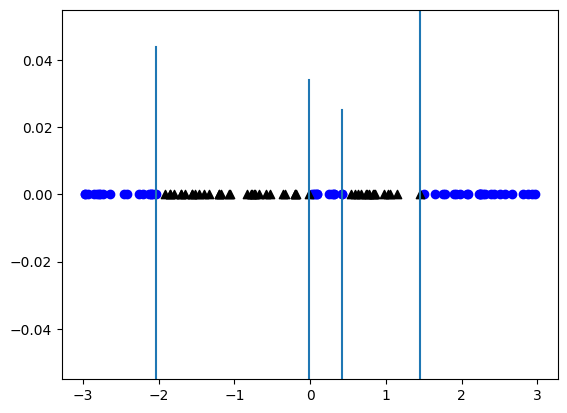

In [10]:
plot_1dtree(x, y, info_gain, 2)

In [11]:
y = rng.choice([0, 1], p=[0.5, 0.5], size=len(x))

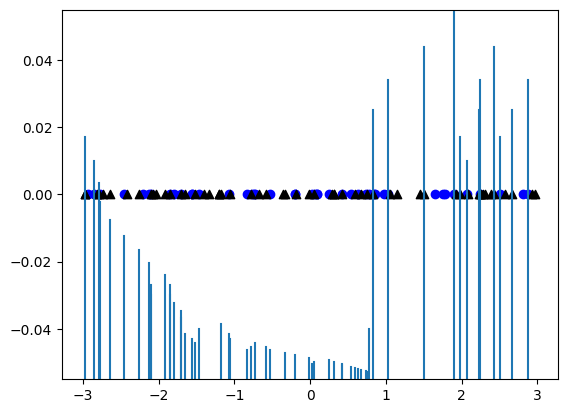

In [12]:
plot_1dtree(x, y, info_gain, 2)

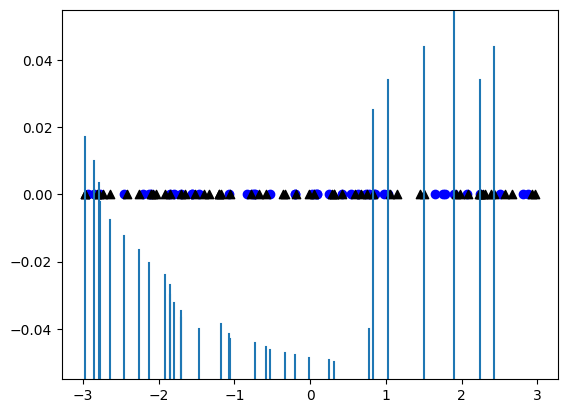

In [13]:
plot_1dtree(x, y, info_gain, 10)

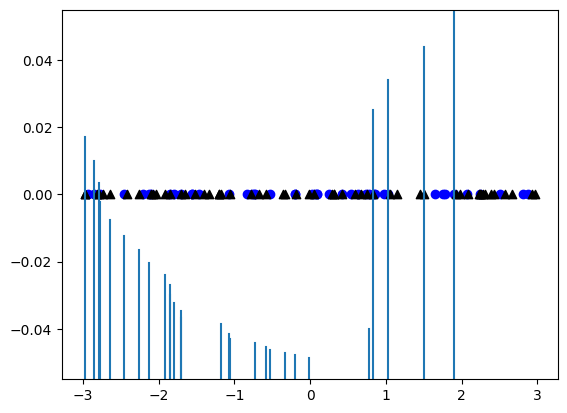

In [14]:
plot_1dtree(x, y, info_gain, 20)

### 1.1.1. E regressão, como fica?

Em regressão temos um target continuo. Logo, outros tipos de heurísticas devem ser utilizadas.

Ilustrarei uma das heurísticas, que é equivalente à operação padrão utilizada no `sklearn`.

Redução de variância:

$VR = Var(y) - \dfrac{|y_l|}{|y|}Var(y_l) - \dfrac{|y_r|}{|y|}Var(y_r)$

In [15]:
def vr(x, y, limiar, min_sample_split=5):
    n = len(y)
    vr = np.var(y, ddof=1)
    y_l = y[x <= limiar]
    y_r = y[x > limiar]

    if len(y_l) < min_sample_split or len(y_r) < min_sample_split:
        return 0

    vr -= (len(y_l) / n) * np.var(y_l, ddof=1)
    vr -= (len(y_r) / n) * np.var(y_r, ddof=1)

    return vr


In [16]:
y = np.zeros(len(x))

y[x <= 0] = rng.normal(-1, 0.1, size=len(np.where(x <= 0)[0]))
y[x > 0] = rng.normal(1, 0.1, size=len(np.where(x > 0)[0]))

In [17]:
split = melhor_split(testa_todos(x, y, vr))

In [18]:
# ramo da esquerda
np.mean(y[x <= split[0]])

-1.012348222839951

In [19]:
# ramo da esquerda
np.mean(y[x > split[0]])

0.9907787247627334

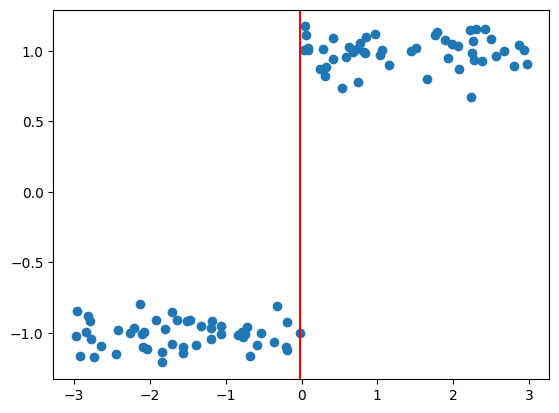

In [20]:
plt.scatter(x, y)
plt.axvline(split[0], ymin=min(y), ymax=max(y), c="red")

## 1.2. Notas sobre as árvores no sklearn

Alguns insights que obtive com a experiência.

### 1.2.1. As árvores não são determinísticas

O sklearn implementa (de forma muito rápida e elegante) as suas estruturas de árvore. De fato, todos os algoritmos de ensemble compartilham do mesmo preditor base.

Para usar a mesma árvore por si só, nas Random Forest e Extra Trees, além de todos os algorítmos de boosting, devem existir prós e contras.

- Por padrão, o sklearn utiliza todas as features para avaliar splits
    - No entanto, devido aos ensembles, subsets das features podem ser utilizadas
- As features são sempre embaralhadas por padrão
    - Se duas features são igualmente "boas" (de acordo com o critério de split) elas podem ser permutadas entre múltiplas execuções
- **Solução:** Sempre fixar a seed de geração de números aleatórios (`random_state`)

In [21]:
from sklearn.tree import export_text

rng = np.random.default_rng(7)
X = np.zeros((1000, 4))

X[:, 0] = rng.normal(0, 1, 1000)
X[:, 1] = rng.normal(1, 3, 1000)
X[:, 2] = X[:, 0]
X[:, 3] = X[:, 1]

y = rng.choice([0, 1], size=1000, p=[0.3, 0.7])


In [22]:
dt = DecisionTreeClassifier(random_state=7, max_depth=2)
dt.fit(X, y)

r = export_text(dt, feature_names=["A", "B", "C", "D"])
print(r)

|--- B <= 6.30
|   |--- D <= 4.13
|   |   |--- class: 1
|   |--- D >  4.13
|   |   |--- class: 1
|--- B >  6.30
|   |--- D <= 9.48
|   |   |--- class: 1
|   |--- D >  9.48
|   |   |--- class: 0



In [23]:
dt = DecisionTreeClassifier(random_state=10001, max_depth=2)
dt.fit(X, y)

r = export_text(dt, feature_names=["A", "B", "C", "D"])
print(r)

|--- D <= 6.30
|   |--- D <= 4.13
|   |   |--- class: 1
|   |--- D >  4.13
|   |   |--- class: 1
|--- D >  6.30
|   |--- D <= 9.48
|   |   |--- class: 1
|   |--- D >  9.48
|   |   |--- class: 0



### 1.2.2. A configuração padrão do sklearn tem grandes chances de gerar overfitting

Por padrão, o `sklearn` não restringe em basicamente nada as suas árvores.
Não tem problema algum nisso, mas devemos ficar "espertos" para utilizar as árvores.

**Exemplo:**

In [24]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

data = load_digits()

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42, shuffle=True)

In [25]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

accuracy_score(y_train, dt.predict(X_train)), accuracy_score(y_test, dt.predict(X_test))

(1.0, 0.8416666666666667)

In [26]:
dt.get_depth()

15

In [27]:
dt = DecisionTreeClassifier(random_state=42, max_depth=10)

dt.fit(X_train, y_train)

accuracy_score(y_train, dt.predict(X_train)), accuracy_score(y_test, dt.predict(X_test))

(0.9686847599164927, 0.85)

In [28]:
dt.get_depth()

10

## 1.3. Ajuste de hiper-parâmetros

As árvores contam com vários parâmetros para ajuste. Mas quais são mais interessantes de focar?

>  Em geral, queremos restringir as árvores (especialmente de uma forma "esperta") para que possamos evitar overfitting.

Dentre os parâmetros que valem a pena checar:

- `max_depth`
- `min_samples_split`
- `min_samples_leaf`
- `min_weight_fraction_leaf`
- `max_leaf_nodes`
- `min_impurity_decrease`
- `ccp_alpha`

Várias possibilidades!

Na minha humilde opinião, nem todos precisam ser ajustados ao mesmo tempo. Em minha visão, esses hiper-parâmetros poderiam ser agrupados. Uma possibilidade seria ajustar um grupo de parâmetros, ou até mesmo uma combinação de grupos.

Eis aqui a minha visão pessoal:

1. Pré-poda:
    - **A:** limitação "cega" - não leva em conta as heurísticas de split
        - `max_depth`, `max_leaf_nodes`
    - **B:** limitação que não leva as heurísticas de split diretamente em conta
        - `min_samples_leaf`, `min_samples_split`, `min_weight_fraction_leaf`
    - **C:** limitação que considera as heurísticas de split
        - `min_impurity_decrease`
2. Pós-poda:
    - `ccp_alpha`

---

Questão para reflexão:

> Qual a diferença prática entre as estruturas geradas por uma árvore restringida via altura máxima e as outras estratégias?

---

De resto, as técnicas de ajuste de hiper-parâmetro se aplicam como usual.

**Obs:**

> É possível dar pesos diferentes para as classes -> cenários com desbalanceamento, por exemplo.

# 2. Receita de ensemble feito em casa

- Motivação: a união faz a força
- Precisamos de modelos adequados para a tarefa

In [29]:
import pandas as pd

from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_diabetes
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold

X, y = load_diabetes(as_frame=True, return_X_y=True)

res = cross_validate(
    KNeighborsRegressor(),
    X=X,
    y=y,
    cv=KFold(n_splits=10, shuffle=True, random_state=3),
    scoring={
        "RMSE": make_scorer(mean_squared_error, squared=False),
        "R2": make_scorer(r2_score)
    }
)

res = pd.DataFrame(res)
res.mean(axis=0)


fit_time       0.001573
score_time     0.001093
test_RMSE     61.454312
test_R2        0.343593
dtype: float64

In [30]:
res.std()

fit_time      0.000597
score_time    0.000323
test_RMSE     6.123751
test_R2       0.075394
dtype: float64

In [31]:
from sklearn.base import BaseEstimator, RegressorMixin


class EnganaNN(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators: int, perc_data: float, random_state: int = None):
        self.n_estimators = n_estimators
        self.perc_data = perc_data
        self.random_state = None
        
        self._rng = np.random.default_rng(self.random_state)
        self._models = [
            KNeighborsRegressor(n_neighbors=1) for _ in range(self.n_estimators)
        ]
    
    def fit(self, X: pd.DataFrame, y: pd.Series, **kwargs):
        # Qtd de linhas no X
        n = len(X)
        # Tamanho da amostra
        size_sample = int(round(self.perc_data * n))

        for i in range(self.n_estimators):
            sel = np.arange(n)
            # Embaralha
            self._rng.shuffle(sel)

            # Filtra a porcentagem de elementos selecionados
            sel = sel[:size_sample]
            
            # Filtra a amostra aleatório selecionada
            X_tr = X.iloc[sel, :]
            y_tr = y.iloc[sel]
            
            self._models[i].fit(X_tr, y_tr)
    
    def predict(self, X: pd.DataFrame):
        preds = np.zeros(len(X))
        
        for i in range(self.n_estimators):
            preds += self._models[i].predict(X)
            
        return preds / self.n_estimators

In [32]:
res_gambiarra = cross_validate(
    EnganaNN(n_estimators=100, perc_data=0.15, random_state=10),
    X=X,
    y=y,
    cv=KFold(n_splits=10, shuffle=True, random_state=3),
    scoring={
        "RMSE": make_scorer(mean_squared_error, squared=False),
        "R2": make_scorer(r2_score)
    }
)

res_gambiarra = pd.DataFrame(res_gambiarra)
res_gambiarra.mean(axis=0)

fit_time       0.134103
score_time     0.107721
test_RMSE     57.769593
test_R2        0.419073
dtype: float64

In [33]:
res_gambiarra.std(axis=0)

fit_time      0.026928
score_time    0.005214
test_RMSE     5.036140
test_R2       0.062125
dtype: float64

In [34]:
import pandas as pd

from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_diabetes
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import BaggingRegressor

X, y = load_diabetes(as_frame=True, return_X_y=True)

res = cross_validate(
    BaggingRegressor(
        estimator=KNeighborsRegressor(n_neighbors=1),
        bootstrap=False,
        n_estimators=100,
        max_samples=0.1
    ),
    X=X,
    y=y,
    cv=KFold(n_splits=10, shuffle=True, random_state=3),
    scoring={
        "RMSE": make_scorer(mean_squared_error, squared=False),
        "R2": make_scorer(r2_score)
    }
)

res = pd.DataFrame(res)
res.mean(axis=0)


fit_time       0.083302
score_time     0.039240
test_RMSE     58.332880
test_R2        0.408584
dtype: float64

# 3. Viés e variância revisitados: ensembles baseados em Bagging

- Bagging => Amostragem com reposição
    - Exemplo: sorteio de itens de uma caixa, após a retirada de um item, este é devolvido

- Redução da variância
- Vimos no começo do curso que a variância e o viés se contrapoem:
    - Se aumentamos o viés, diminuímos a variância. E vice-versa.

- Viés alto -> underfitting
- Variância alta -> overfitting

- A princípio, overffiting parece algo sempre "maléfico", mas no quesito dos ensembles baseados em bagging, esse sobreajuste pode vir a calhar.

- Combinação de preditores com alta variância
    - Individualmente, razoavelmente fortes
    - Mas não o suficiente para que possa haver diversidade em suas respostas
    - Consenso nem sempre é bom!

Por que as árvores de decisão são tão populares em ensembles?

In [35]:
data = load_digits()

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42, shuffle=True)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

accuracy_score(y_test, dt.predict(X_test)), dt.get_depth(), dt.get_n_leaves()

(0.8416666666666667, 15, 145)

In [36]:
data = load_digits()

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=43, shuffle=True)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

accuracy_score(y_test, dt.predict(X_test)), dt.get_depth(), dt.get_n_leaves()

(0.8361111111111111, 14, 154)

In [37]:
data = load_digits()

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=44, shuffle=True)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

accuracy_score(y_test, dt.predict(X_test)), dt.get_depth(), dt.get_n_leaves()

(0.8444444444444444, 13, 148)

Por que isso acontece? Vamos voltar ao nosso exemplo lá do início:

In [38]:
rng = np.random.default_rng(7)

x = rng.uniform(-3, 3, 100)
y = np.array(
    [0 if xi <= 0 else 1 for xi in x]
)

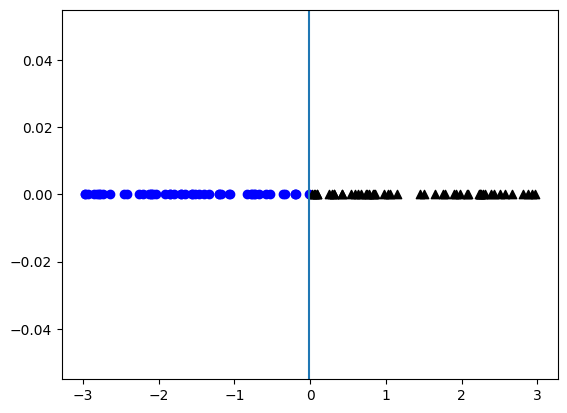

In [39]:
plot_1dtree(x, y, info_gain, 2)

Deixa eu bagunçar um pouco esses dados:

In [40]:
np.where(y==0)

(array([ 3,  4,  6,  9, 10, 11, 12, 13, 20, 21, 23, 24, 26, 30, 31, 32, 33,
        35, 36, 37, 39, 40, 46, 50, 52, 53, 54, 55, 57, 63, 64, 65, 66, 67,
        69, 71, 74, 79, 80, 83, 87, 88, 89, 90, 92, 94, 96, 97, 98, 99],
       dtype=int64),)

In [41]:
# Selecionei 3 posições arbitrárias para permutar as labels
y[np.array([9, 87, 94])] = 1

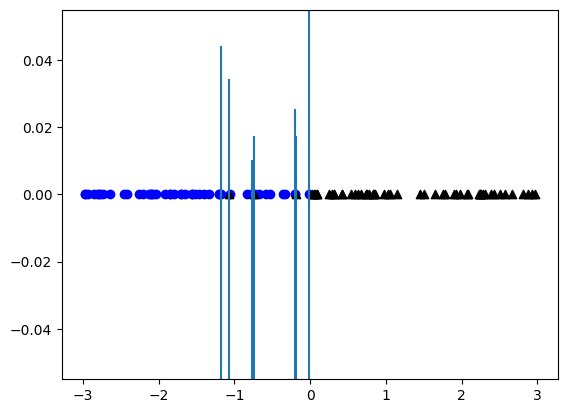

In [42]:
plot_1dtree(x, y, info_gain, 2)

Desafio:

> O que está acontecendo?

E se restringirmos as coisas (nesse caso, restringirmos bastante)?

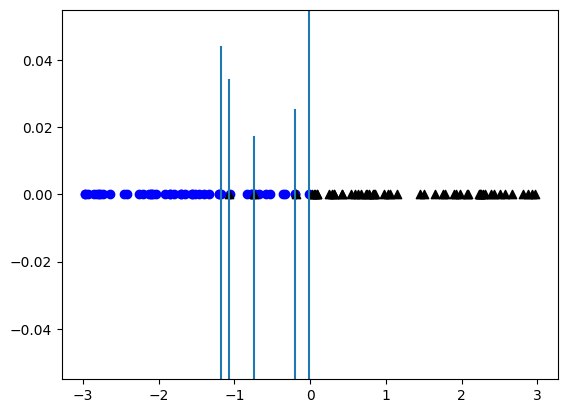

In [43]:
plot_1dtree(x, y, info_gain, 10)

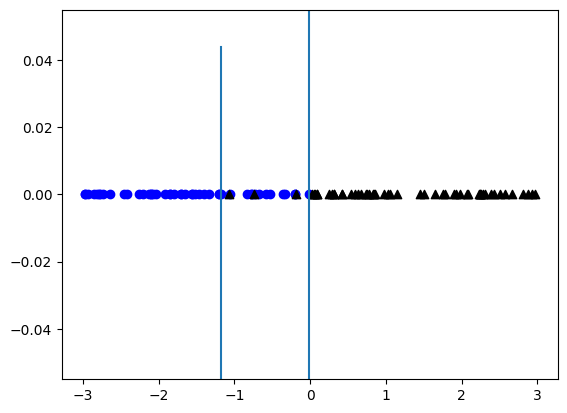

In [44]:
plot_1dtree(x, y, info_gain, 20)

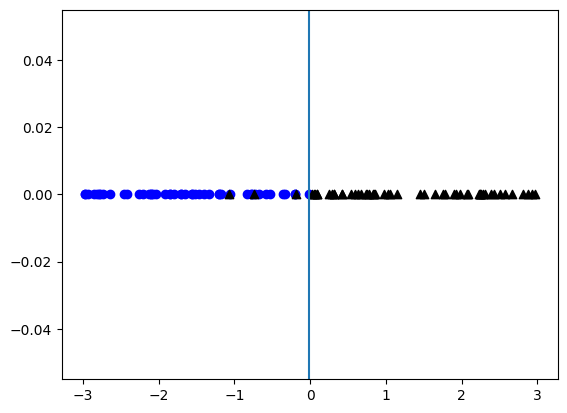

In [45]:
plot_1dtree(x, y, info_gain, 60)

Uma pequena mudança nos dados acarreta grandes mudanças no modelo gerado!

Alta variância! :)

---

Que lições podemos tomar disso já de antemão se formos pensar em ensembles com bagging?

> Pode ser uma boa ideia deixar as árvores em um ensemble baseado em bagging "voarem livres" ou com pouca restrição.

**Por quê?**

---

Note que a Random Forest e outros ensembles similares utilizam mais de uma estratégia para induzir diversidade entre seus membros.

# 4. Comparando o efeito de bagging em algoritmos de AM

In [46]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold, cross_val_score

In [147]:
dataset = load_digits()

kf = KFold(10, random_state=42, shuffle=True)

## 4.1. Árvores de decisão

Vamos avaliar o efeito do bagging em algumas famílias de algoritmos preditivos.

### 4.1.1. Individualmente

In [48]:
accs = cross_val_score(
    DecisionTreeClassifier(random_state=7),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.8530881440099316, 0.01944492992746197)

In [49]:
dt = DecisionTreeClassifier(random_state=7)
dt.fit(dataset.data, dataset.target)
dt.get_depth()

15

In [50]:
accs = cross_val_score(
    DecisionTreeClassifier(random_state=7, min_impurity_decrease=0.001),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.8536499068901303, 0.026638844899314937)

In [51]:
dt = DecisionTreeClassifier(random_state=7, min_impurity_decrease=0.001)
dt.fit(dataset.data, dataset.target)
dt.get_depth()

13

### 4.1.2. Bagging

Sem restrições

In [52]:
accs = cross_val_score(
    BaggingClassifier(
        DecisionTreeClassifier(random_state=7),
        random_state=42
    ),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.9426722532588453, 0.024417959316653266)

Restringindo a profundidade máxima da árvore

In [53]:
accs = cross_val_score(
    BaggingClassifier(
        DecisionTreeClassifier(random_state=7, max_depth=5),
        random_state=42
    ),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.8447206703910615, 0.03160038400933399)

**Desafio:**

> O que está acontecendo?

## 4.2 Redes Neurais

Não irei me aprofundar nas configurações das redes de forma alguma. O objetivo aqui é apenas ilustrativo.

In [54]:
from sklearn.neural_network import MLPClassifier

### 4.2.1. Individualmente

In [55]:
accs = cross_val_score(
    MLPClassifier(random_state=1),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.9749472377405338, 0.010673384168204585)

In [56]:
accs = cross_val_score(
    MLPClassifier(random_state=2),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.9766263190564868, 0.008917059509584855)

### 4.2.2. Bagging

In [57]:
accs = cross_val_score(
    BaggingClassifier(
        MLPClassifier(random_state=1),
        random_state=42
    ),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.9821942892613285, 0.008173977170808814)

## 4.3. k-NN

Quais são as apostas para o k-NN?

### 4.3.1. Individualmente

In [58]:
from sklearn.neighbors import KNeighborsClassifier

accs = cross_val_score(
    KNeighborsClassifier(),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.9883147113594042, 0.010417587176862671)

### 4.3.2. Bagging

In [59]:
accs = cross_val_score(
    BaggingClassifier(
        KNeighborsClassifier(),
        random_state=42
    ),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.9849720670391061, 0.011424418696637679)

## 4.4. Naive Bayes

### 4.4.1. Individualmente

In [60]:
from sklearn.naive_bayes import GaussianNB


accs = cross_val_score(
    GaussianNB(),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.8430757293606457, 0.030080295731662536)

### 4.4.2. Bagging

In [61]:
accs = cross_val_score(
    BaggingClassifier(
        GaussianNB(),
        random_state=42
    ),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.8603320918684046, 0.02546603049645491)

## 4.5. Regressão Logistica

Façam suas apostas!

### 4.5.1. Individualmente


In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


accs = cross_val_score(
    Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=1, max_iter=200))
    ]),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.96548417132216, 0.012460053918938133)

### 4.5.2. Bagging

In [ ]:
accs = cross_val_score(
    Pipeline([
        ('scaler', StandardScaler()),
        ('model', BaggingClassifier(LogisticRegression(random_state=1, max_iter=200), random_state=42))
    ]),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

In [80]:
rng = np.random.default_rng(7)

In [81]:
dados = np.arange(20)
# rng.shuffle(dados)
dados

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [84]:
rng.choice(dados, 20, replace=True)

array([ 9,  4, 16,  3, 17, 12,  2,  0,  8,  0,  2, 10, 19,  9, 16, 18, 16,
       12,  8, 10])

In [85]:
bagg = BaggingClassifier(
    DecisionTreeClassifier(random_state=1),
    random_state=42
)

bagg.fit(X=dataset.data, y=dataset.target)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1),
                  random_state=42)

In [88]:
bagg.estimators_[0]

DecisionTreeClassifier(random_state=1952926171)

In [99]:
r = export_text(bagg.estimators_[5], feature_names=dataset.feature_names, max_depth=2)
print(r)

|--- pixel_4_4 <= 0.50
|   |--- pixel_5_2 <= 5.00
|   |   |--- pixel_1_5 <= 7.50
|   |   |   |--- truncated branch of depth 3
|   |   |--- pixel_1_5 >  7.50
|   |   |   |--- truncated branch of depth 3
|   |--- pixel_5_2 >  5.00
|   |   |--- pixel_2_5 <= 0.50
|   |   |   |--- truncated branch of depth 4
|   |   |--- pixel_2_5 >  0.50
|   |   |   |--- truncated branch of depth 3
|--- pixel_4_4 >  0.50
|   |--- pixel_7_4 <= 7.50
|   |   |--- pixel_2_5 <= 0.50
|   |   |   |--- truncated branch of depth 3
|   |   |--- pixel_2_5 >  0.50
|   |   |   |--- truncated branch of depth 8
|   |--- pixel_7_4 >  7.50
|   |   |--- pixel_3_2 <= 5.50
|   |   |   |--- truncated branch of depth 9
|   |   |--- pixel_3_2 >  5.50
|   |   |   |--- truncated branch of depth 10



# 5. Random Patches

Até o momento, nós focamos em apenas uma estratégia de perturbação nos dados:

> Bagging

Induzir diversidade.

Existem mais formas de fazer isso. Outra forma muito popular é a utilização de sub-conjuntos de features para induzir cada preditor.

**Atenção:**

- Bagging: amostragem com reposição
- Sub-conjuntos de features: amostragem sem reposição (abordagem mais usual)

---
Qual é o efeito de sub-amostrarmos features?

- O que acontece em uma árvore de decisão?
- O que acontece no k-NN?
- Quando isso pode ser mais ou menos efetivo?

---

A combinação de bagging e sub-conjuntos de features por preditor base resulta no algorítmo chamado: *Random Patches*.

**Atenção (de novo):**

> A sub-amostragem de features por preditor base é **global** no Random Patches.

Vamos ver na prática:

## 5.1. Árvores de Decisão + Bagging


In [100]:
accs = cross_val_score(
    BaggingClassifier(
        DecisionTreeClassifier(random_state=1),
        random_state=42
    ),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.9426722532588453, 0.024417959316653266)

## 5.2. Árvores de Decisão + Random Patches

In [105]:
accs = cross_val_score(
    BaggingClassifier(
        DecisionTreeClassifier(random_state=1),
        random_state=42,
        max_features=round(0.6 * dataset.data.shape[1])
    ),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.9560397268777157, 0.013262056235052212)

In [117]:
rp = BaggingClassifier(
    DecisionTreeClassifier(random_state=1),
    random_state=42,
    max_features=round(0.6 * dataset.data.shape[1])
)

rp.fit(X=dataset.data, y=dataset.target)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1),
                  max_features=38, random_state=42)

In [118]:
r = export_text(rp.estimators_[5], max_depth=2)
print(r)

|--- feature_5 <= 0.50
|   |--- feature_8 <= 0.50
|   |   |--- feature_25 <= 6.00
|   |   |   |--- truncated branch of depth 3
|   |   |--- feature_25 >  6.00
|   |   |   |--- truncated branch of depth 2
|   |--- feature_8 >  0.50
|   |   |--- feature_9 <= 10.50
|   |   |   |--- truncated branch of depth 3
|   |   |--- feature_9 >  10.50
|   |   |   |--- truncated branch of depth 4
|--- feature_5 >  0.50
|   |--- feature_21 <= 1.50
|   |   |--- feature_28 <= 2.50
|   |   |   |--- truncated branch of depth 5
|   |   |--- feature_28 >  2.50
|   |   |   |--- truncated branch of depth 9
|   |--- feature_21 >  1.50
|   |   |--- feature_4 <= 7.50
|   |   |   |--- truncated branch of depth 7
|   |   |--- feature_4 >  7.50
|   |   |   |--- truncated branch of depth 11



# 6. Random Forest

O Random Patches, por fazer sub-amostragem de features a nível global, pode ser aplicado a qualquer algoritmo.

A Random Forest vai um passo além, no quesito indução de diversidade.

Ao invés de subamostrar features globalmente, as RFs

> Realização a sub-amostragem de features a nível **local**

Mas como?

Durante cada tentativa de split, em cada nó, um novo sub-conjunto de features é amostrado (sem reposição).

---

**Desafio:**

> Qual a vantagem de se fazer isso?

---

Em contrapartida, agora estamos limitados a árvores de decisão.

In [119]:
from sklearn.ensemble import RandomForestClassifier

accs = cross_val_score(
    RandomForestClassifier(
        random_state=42,
        max_features=round(0.6 * dataset.data.shape[1]),
        n_estimators=10
    ),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.9499348230912477, 0.019846912012364108)

In [121]:
dataset.data.shape, 64 ** 0.5

((1797, 64), 8.0)

In [144]:
accs = cross_val_score(
    RandomForestClassifier(
        random_state=42,
    ),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.967169459962756, 0.012778994081111633)

Fronteiras de decisão

In [124]:
# Adaptado de: https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Utilities/ML-Python-utils.py
def plot_decision_boundaries(X, y, model):
    from matplotlib import colormaps
    import matplotlib.markers as mmarkers
    def mscatter(x, y, ax=None, m=None, **kw):
        if not ax: ax=plt.gca()
        sc = ax.scatter(x,y,**kw)
        if (m is not None) and (len(m)==len(x)):
            paths = []
            for marker in m:
                if isinstance(marker, mmarkers.MarkerStyle):
                    marker_obj = marker
                else:
                    marker_obj = mmarkers.MarkerStyle(marker)
                path = marker_obj.get_path().transformed(
                            marker_obj.get_transform())
                paths.append(path)
            sc.set_paths(paths)
        return sc

    try:
        X = np.array(X)
        y = np.array(y).flatten()
    except:
        print("Coercing input data to NumPy arrays failed")

    # Reduces to the first two columns of data
    reduced_data = X[:, :2]
    # Fits the model with the reduced data
    model.fit(reduced_data, y)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Right now it only works with binary tasks: expand both dictionaries or use cmap for multiclass tasks

    cmap = colormaps['brg']

    markers = {0: "o", 1: "^", 2: "s", 3: "D", 4: "+", 5: "*"}

    m = list(map(lambda i: markers[i], y))
    
    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    mscatter(x=X[:, 0], y=X[:, 1], c=y, m=m, cmap=cmap, alpha=1)
    
    plt.xlabel("x1",fontsize=15)
    plt.ylabel("x2",fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    return plt

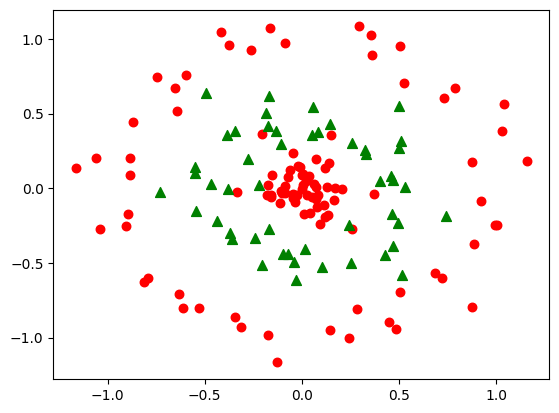

In [128]:
from sklearn.datasets import make_circles


X_orig, y = make_circles(n_samples=100, factor = 0.5, noise = 0.1, random_state = 42)

X = StandardScaler().fit_transform(X_orig)
X_in, y_in = make_circles(n_samples=100, factor = 0.1, noise = 0.1, random_state = 42)

# Pega o X interno
mask = (y_in == 1)
X_in = X_in[mask]

# Inverte a label do miolo
y_in = np.zeros(len(y_in[mask]))

X2 = np.concatenate((X_orig, X_in), axis=0,)
y2 = np.concatenate((y, y_in), axis=0)

colors = ["red", "green"]
markers = [".", "^"]
sizes = [150, 50]
for c in [0, 1]:
    mask = y2 == c
    plt.scatter(X2[mask, 0], X2[mask, 1], color=colors[c], marker=markers[c], s=sizes[c])
plt.show()

<module 'matplotlib.pyplot' from 'C:\\Users\\SauloMastelini\\miniconda3\\envs\\uel\\lib\\site-packages\\matplotlib\\pyplot.py'>

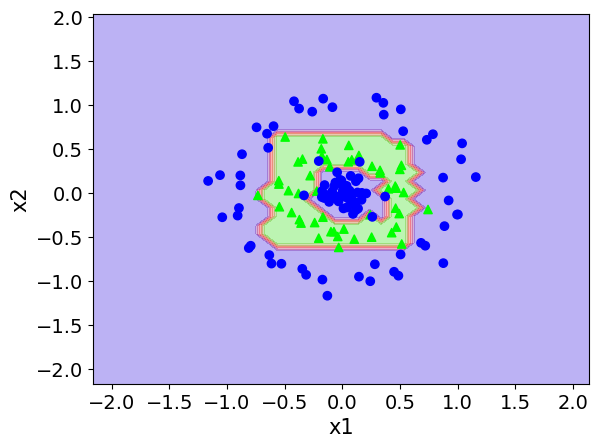

In [130]:
plot_decision_boundaries(X2, y2, RandomForestClassifier(random_state=150423))

In [131]:
rf = RandomForestClassifier(random_state=0)
rf.fit(dataset.data, dataset.target)

RandomForestClassifier(random_state=0)

In [135]:
r = export_text(rf.estimators_[3], max_depth=2)
print(r)

|--- feature_34 <= 5.50
|   |--- feature_38 <= 0.50
|   |   |--- feature_26 <= 3.50
|   |   |   |--- truncated branch of depth 7
|   |   |--- feature_26 >  3.50
|   |   |   |--- truncated branch of depth 10
|   |--- feature_38 >  0.50
|   |   |--- feature_29 <= 12.50
|   |   |   |--- truncated branch of depth 9
|   |   |--- feature_29 >  12.50
|   |   |   |--- truncated branch of depth 8
|--- feature_34 >  5.50
|   |--- feature_38 <= 0.50
|   |   |--- feature_58 <= 8.50
|   |   |   |--- truncated branch of depth 10
|   |   |--- feature_58 >  8.50
|   |   |   |--- truncated branch of depth 9
|   |--- feature_38 >  0.50
|   |   |--- feature_58 <= 0.50
|   |   |   |--- truncated branch of depth 8
|   |   |--- feature_58 >  0.50
|   |   |   |--- truncated branch of depth 11



## 6.1. E agora? E para tunar?

As RFs contam com vários parâmetros por si só, e ainda trazem os parâmetros dos modelos base (árvores). E agora?

Aqui vai uma pitada da minha experiência pessoal. O que focar?

- `n_estimators`: no entanto, existe um ponto de saturação
    - mais árvores != mais acurácia. Isso é até bom!
- `max_features`: eu diria que esse é o parâmetro mais sensível

O paper do Breiman introduzindo as RFs foca nesses dois parâmetros.

Desconheço a existência de consenso quanto as vantagens (ou desvantagens) de se podar as árvores na floresta. O que eu faço normalmente? Deixo as árvores crescerem sem restrições.

Um coisa incrível sobre as RFs? O desempenho delas normalmente não varia muito após o ajuste de hiper-parâmetros.

**Dica:**

Ao se deparar com um novo problema eu costumo:

1. Testar um baseline simples
2. Testar um modelo linear
3. Testar uma RF com os hiper-parâmetros padrão

## 6.2. Feature importance

Existem algumas maneiras de se estimar a importância das features a partir de uma floresta de árvores. Por padrão, o `sklearn` utiliza um algoritmo de calculo de importância baseado na soma do decréscimo médio na impureza de cada árvore.

Para utilizá-lo:



In [152]:
from sklearn.datasets import load_iris

dataset = load_iris()

# Não me julguem por usar o conjunto inteiro, o propósito é fazer algo didático
rf = RandomForestClassifier(random_state=42)
rf.fit(dataset.data, dataset.target)

RandomForestClassifier(random_state=42)

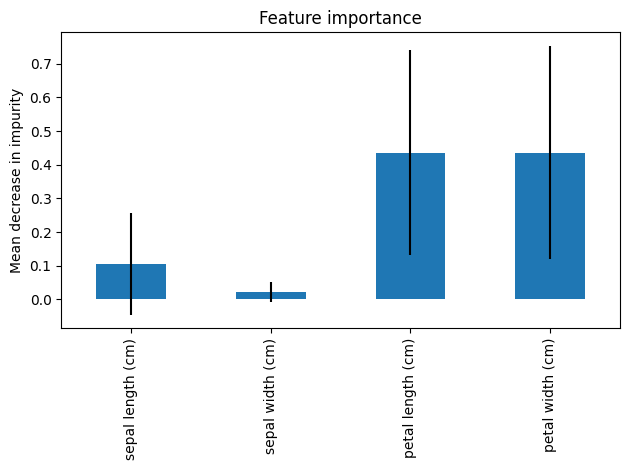

In [153]:
import pandas as pd

importances = rf.feature_importances_

# Opcional, mas interessante
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

importances = pd.Series(importances, index=dataset.feature_names)

fig, ax = plt.subplots()
importances.plot.bar(
    yerr=std,
    ax=ax)
ax.set_title("Feature importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Eu vou descrever uma alternativa mais custosa, porém mais confiável. Esse algoritmo para cálculo de importância das features é descrito no artigo do Breiman, onde as Random Forest (também) foram introduzidas.

---

O Bagging nos dá algo de brinde:

- Cada árvore tem um conjunto de amostras que nunca foi utilizado para treino: amostras Out-of-Bag (OOB).
- Com as amostras OOB podemos calcular OOBE (e essa estimativa não é enviesada, como treinar e testar com os mesmos dados!)

Com esses ingredientes, podemos dar um passo além e estimarmos uma medida de importância de feature:

**RF Feature Importance (Permutation):**

1. Para cada feature:
    1. Calcule o OOBE
    2. Permute os valores da feature aleatoriamente
    3. Recalcule o OOBE para os dados permutados
    4. Calcule a diferença
2. (Opcional) Normalize os valores obtidos

O `sklearn` não implementa essa opção diretamente. A implementação padrão de RF no R tem essa opção.

No entanto, podemos simular algo parecido essa estratégia utilizando a função `permutation_importance` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)), que está disponível no módulo `inspection` do `sklearn`. No entanto, precisamos passar um conjunto de testes para o cálculo das importâncias.

## 6.3. E dá para "bagunçar" mais?

Até agora a nossa "receita" de ensemble inclui:

- `n_estimators` preditores com alta variância (de preferência árvores de decisão)
- bagging
- sub-amostragem (local, no caso de árvores) de features

No caso da RF, temos que em cada split um novo sub-conjunto de features é amostrado e o melhor ponto, dentre a melhor das features é selecionada para criar um nó de decisão.

Como poderíamos deixar mais aleatório esse processo?

> Extra Trees!

- Usa sub-conjuntos de features assim como a RF, no entanto, os pontos de split também são aleatórios!
- Escolhe o melhor ponto aleatório de split no sub-conjunto de features selecionadas 

In [154]:
from sklearn.ensemble import ExtraTreesClassifier

accs = cross_val_score(
    ExtraTreesClassifier(
        random_state=42,
        max_features="sqrt",
    ),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.9600000000000002, 0.05333333333333332)

Por padrão, as Extra Trees não usam Bagging (bootstrap sampling). Mas esse padrão pode ser modificado:

In [155]:
accs = cross_val_score(
    ExtraTreesClassifier(
        random_state=42,
        bootstrap=True,
        max_features="sqrt"
        
    ),
    X=dataset.data,
    y=dataset.target,
    cv=kf,
    scoring="accuracy"
)
np.mean(accs), np.std(accs)

(0.9600000000000002, 0.05333333333333332)

Qual é o impacto da mudança na estratégia de particionamento das árvores?

In [156]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=5000, n_features=20, n_classes=5, n_informative=15,
    random_state=8
)

In [157]:
%%timeit

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

2.6 s ± 37.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [158]:
%%timeit

xt = ExtraTreesClassifier(random_state=42)
xt.fit(X, y)

776 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Tarefa

1. Descreva, com suas palavras, os "ingredientes necessários" para se compor um ensemble de forca eficaz. Considere formas de se perturbar os dados e as características dos modelos.

**R:**

2. Por quais razões tanto a utilização de árvores muito rasas quanto adição de muitas árvores não é benéfica para a Random Forest?

**R:**